# Use Transfer Learning for Sun Spotter
## Try different pre trained models e.g. resnet_v2_152, inception_resnet_v2, mobilenet etc.

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import time
import PIL.Image as Image
import tensorflow_hub as hub

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Create callback instances
### Setup folder where to save logs for tensorboard, one folder for every run

In [2]:
#setup folder where to save logs for tensorflow
root_logdir = os.path.join(os.curdir,"my_logs")

def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()

In [3]:
#create keras Tensorboard callback
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

### Setup callback for ModelCheckpoint to save the model

In [4]:
#create keras ModelCheckpoint callback
checkpoint_cb = keras.callbacks.ModelCheckpoint("sunSpotter_keras_transferLearning_model.h5")

### Setup callback for Early Stopping

In [5]:
#create keras early stopping callback will be used later on
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

## Use a pretrained model

### Preparation to make it easy to try out different models

#### Use head-less pretrained Model for CNN
We tried the following models:
* Use trainable=False to freeze the variables in the feature extractor layer, so that the training only modifies the new classifier layer.   
* Use trainable=True to fine tune the variables in the feature extractor layer.
   
| "Model"        | "Fine tuned?"| "Training loss"  | "Training accuracy"  | "Validation loss" | "Validation accuracy" | "Commments"
| :------------- |:-------------:| :-------------:| :-----: |:-----:| :-----: | ------------- :|
| resnet_v2_50  | yes              |0.7248 | 0.9413  |  0.8801 | 0.8594 | generalizes bad (always 100% confidence in one class)
| resnet_v2_50  | no               |0.8994 |  0.5831  | 0.8569 | 0.5375 |generalizes bad (always 100% confidence in one class)
| inception_resnet_v2   | yes      | 1.0882 | 0.8742 | 1.8426 | 0.5250 |generalizes bad (always 100% confidence in one class)
| inception_resnet_v2   | no      |   0.6287 |0.8308  | 0.9929 | 0.6219 |generalizes bad (always 100% confidence in one class)
| mobilenet_v2_140_224| yes      |   0.5639| 0.9345 |  1.0495 | 0.6125 | second best results
| mobilenet_v2_140_224| no      |  0.6338 |0.9345  |0.7113 | 0.7750 | **_best validation loss & generalizes best_**

#### Own CNN-Model with 5 convolution layers
| "Model"        | "Fine tuned?"| "Training loss"  | "Training accuracy"  | "Validation loss" | "Validation accuracy" | "Commments"
| :------------- |:-------------:| :-------------:| :-----: |:-----:| :-----: | ------------- :|
| selfmade model  | -              | 0.3565 |  0.8442  |  0.3142 | 0.8592 | lowest loss and high accuracy but generalizes not good



In [6]:
model_name = "mobilenet_v2_140_224" # @param ['bit_s-r50x1', 'efficientnet_b0', 'efficientnet_b1', 'efficientnet_b2', 'efficientnet_b3', 'efficientnet_b4', 'efficientnet_b5', 'efficientnet_b6', 'efficientnet_b7', 'inception_v3', 'inception_resnet_v2', 'mobilenet_v2_100_224', 'mobilenet_v2_130_224', 'mobilenet_v2_140_224', 'mobilenet_v3_large_100_224', 'mobilenet_v3_large_075_224', 'mobilenet_v3_small_100_224', 'mobilenet_v3_small_075_224', 'nasnet_large', 'nasnet_mobile', 'pnasnet_large', 'resnet_v1_50', 'resnet_v1_101', 'resnet_v1_152', 'resnet_v2_50', 'resnet_v2_101', 'resnet_v2_152']

model_handle_map = {
  "efficientnet_b0": "https://tfhub.dev/tensorflow/efficientnet/b0/feature_vector/1",
  "inception_v3": "https://tfhub.dev/google/imagenet/inception_v3/feature_vector/4",  
  "inception_resnet_v2": "https://tfhub.dev/google/imagenet/inception_resnet_v2/feature_vector/4",
  "resnet_v1_50": "https://tfhub.dev/google/imagenet/resnet_v1_50/feature_vector/4",
  "resnet_v1_152": "https://tfhub.dev/google/imagenet/resnet_v1_152/feature_vector/4",
  "resnet_v2_50": "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4",
  "resnet_v2_101": "https://tfhub.dev/google/imagenet/resnet_v2_101/feature_vector/4",
  "resnet_v2_152": "https://tfhub.dev/google/imagenet/resnet_v2_152/feature_vector/4",
  "mobilenet_v2_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4",
  "mobilenet_v2_130_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/feature_vector/4",
  "mobilenet_v2_140_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_140_224/feature_vector/4",
}

model_image_size_map = {
  "efficientnet_b0": 224,
  "inception_v3": 299,
  "inception_resnet_v2": 299,
}

model_handle = model_handle_map.get(model_name)
pixels = model_image_size_map.get(model_name, 224)

print(f"Selected model: {model_name} : {model_handle}")

IMAGE_SIZE = (pixels, pixels)
print(f"Input size {IMAGE_SIZE}")

BATCH_SIZE = 32 #@param {type:"integer"}

Selected model: mobilenet_v2_140_224 : https://tfhub.dev/google/imagenet/mobilenet_v2_140_224/feature_vector/4
Input size (224, 224)


### Load the data set

We uses a dataset of about 1639 photos of different landscapes from real webcams. The dataset contains 3 sub-directories, one per class:

```
/
  rainy/
  cloudy/
  sunny/  
```

In [7]:
import pathlib
data_dir = "..\..\data\images-classified"
data_dir = pathlib.Path(data_dir)
print(data_dir)

..\..\data\images-classified


Load and preprocess the data set (in the code under it assumes that every class is contained in a different subfolder, but that can be adapted). In addition perform some data augmentation on the training data. 
Split the dataset in a validation an a training part which will be used by the model. Let's use 80% of the images for training, and 20% for validation.

In [8]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, validation_split=.20)# add data augmentation trasnformations
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, validation_split=.20)#no data augmentation in the validation set

train_generator = train_datagen.flow_from_directory(
    data_dir, subset="training", shuffle=True,target_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
                   interpolation="bilinear")

valid_generator = valid_datagen.flow_from_directory(
    data_dir, subset="validation", shuffle=False, target_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
                   interpolation="bilinear")

Found 1312 images belonging to 3 classes.
Found 327 images belonging to 3 classes.


### Defining the model

First let's create the feature extractor. Use trainable=False to freeze the variables in the feature extractor layer, so that the training only modifies the new classifier layer.

In [9]:
feature_extractor_layer = hub.KerasLayer(model_handle, trainable=False)

Now let's attach a classification head after the feature extractor layer. Thta's mean we need to wrap the hub layer 
in a tf.keras.Sequential model, and add a new classification layer.

For speed, we start out with a non-trainable feature_extractor_layer, but you can also enable fine-tuning for greater accuracy. Just change to trainable = True.  

In [10]:
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
    feature_extractor_layer,
    #tf.keras.layers.Dropout(rate=0.2),    
    tf.keras.layers.Dense(units=128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    layers.Dropout(rate=0.2),
    layers.Dense(units=64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    layers.Dropout(rate=0.2),
    #layers.Dense(units=train_generator.num_classes, activation='softmax')
    tf.keras.layers.Dense(train_generator.num_classes, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
model.build((None,)+IMAGE_SIZE+(3,))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1792)              4363712   
_________________________________________________________________
dense (Dense)                (None, 128)               229504    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 195       
Total params: 4,601,667
Trainable params: 237,955
Non-trainable params: 4,363,712
________________________________________

### Compile & Train the model 

In [11]:
model.compile(
  optimizer=tf.keras.optimizers.SGD(learning_rate=0.005, momentum=0.9), 
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
  metrics=['accuracy'])

In [12]:
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = valid_generator.samples // valid_generator.batch_size
epochs = 2
hist = model.fit(
    train_generator,
    epochs=epochs, steps_per_epoch=steps_per_epoch,
    validation_data=valid_generator,
    validation_steps=validation_steps,  callbacks = [tensorboard_cb, early_stopping_cb, checkpoint_cb]).history

Epoch 1/2
C:\Users\maryl\anaconda3\lib\site-packages\tensorflow\python\keras\backend.py:4869: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(
41/41 [==============================] - 99s 2s/step - loss: 0.8994 - accuracy: 0.6479 - val_loss: 0.9020 - val_accuracy: 0.5844
Epoch 2/2
41/41 [==============================] - 89s 2s/step - loss: 0.6568 - accuracy: 0.8209 - val_loss: 0.7281 - val_accuracy: 0.7469


Let's track the training (one can also use TensorBoard!)

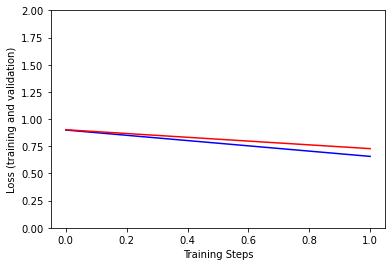

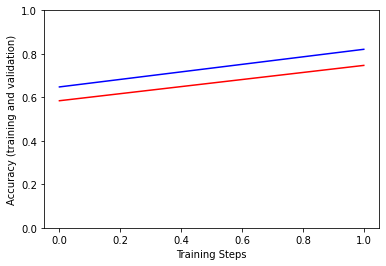

In [13]:
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(hist["loss"], color="blue", label='Training Loss')
plt.plot(hist["val_loss"], color="red", label='Validation Loss')

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["accuracy"], color="blue", label='Training Loss')
plt.plot(hist["val_accuracy"], color="red", label='Validation Loss')

Create plots of loss and accuracy on the training and validation sets.

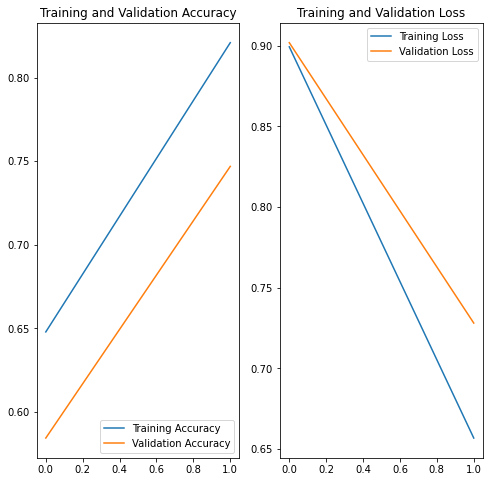

In [14]:
acc = hist['accuracy']
val_acc = hist['val_accuracy']

loss = hist['loss']
val_loss = hist['val_loss']


epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Reload a pretrained model

In [15]:
# Reconstruct the model with keras
model_name_toreload = "mobilenet_v2_140_224"
pretrained_model_path = f"./tmp/saved_sunSpotter_model_{model_name}"

#H5 format
#pretrained_model_path = f"./sunSpotter_keras_transferLearning_model_mobilenet_v2_140_224_finetuned.h5"
pretrained_model_path = f"./sunSpotter_keras_transferLearning_model_mobilenet_v2_140_224.h5"
model = keras.models.load_model(pretrained_model_path, custom_objects={'KerasLayer':hub.KerasLayer})
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_3 (KerasLayer)   (None, 1792)              4363712   
_________________________________________________________________
dense_6 (Dense)              (None, 128)               229504    
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 3)                 195       
Total params: 4,601,667
Trainable params: 237,955
Non-trainable params: 4,363,712
______________________________________

## Predict on trainings data

Try out the model on an image from the validation data:

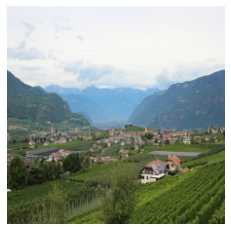

True label: cloudy
Predicted label: cloudy


In [16]:
def get_class_string_from_index(index):
   for class_string, class_index in valid_generator.class_indices.items():
      if class_index == index:
         return class_string

x, y = next(valid_generator)
image = x[0, :, :, :]
true_index = np.argmax(y[0])
plt.imshow(image)
plt.axis('off')
plt.show()

# Expand the validation image to (1, 224, 224, 3) before predicting the label
prediction_scores = model.predict(np.expand_dims(image, axis=0))
predicted_index = np.argmax(prediction_scores)
print("True label: " + get_class_string_from_index(true_index))
print("Predicted label: " + get_class_string_from_index(predicted_index))

show the confidence level of the preditions (most likely and least likely):

In [17]:
score = tf.nn.softmax(prediction_scores[0])
# print score of all classes
print(score)
# print score of most likely class
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(get_class_string_from_index(np.argmax(score)), 100 * np.max(score))
)
# pring score of least likely class
print(
    "This image most unlikely belongs to {} with a {:.2f} percent confidence."
    .format(get_class_string_from_index(np.argmin(score)), 100 * np.min(score))
)

tf.Tensor([0.4170411  0.24466042 0.33829847], shape=(3,), dtype=float32)
This image most likely belongs to cloudy with a 41.70 percent confidence.
This image most unlikely belongs to rainy with a 24.47 percent confidence.


## Predict on new data

Result is unfortunately pretty bad, it doesnt matter if we choose a picture where there is sun or rain, it always predicts the th same class with a 100% confidence. 

In [145]:
#sunny_url = https://www.foto-webcam.eu/webcam/tschagguns/2021/06/01/1140_hu.jpg
#sunny_url = https://www.foto-webcam.eu/webcam/tschagguns/2021/05/28/1510_hu.jpg
#sunny_url = "https://www.foto-webcam.eu/webcam/tschagguns/2021/06/01/1140_hu.jpg"
#sunny_url = "https://www.foto-webcam.eu/webcam/schroecken/2021/06/09/0830_lm.jpg"
#sunny_url = "https://www.foto-webcam.eu/webcam/feldkirch/2021/06/13/0910_lm.jpg"
sunny_url = "https://www.foto-webcam.eu/webcam/brunnen/2021/06/09/0830_lm.jpg"

sunny_path = tf.keras.utils.get_file('SunnyWheater', origin=sunny_url)

img = keras.preprocessing.image.load_img(
    sunny_path, target_size=(IMAGE_SIZE)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(score)
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(get_class_string_from_index(np.argmax(score)), 100 * np.max(score))
)

print(
    "This image most unlikely belongs to {} with a {:.2f} percent confidence."
    .format(get_class_string_from_index(np.argmin(score)), 100 * np.min(score))
)

tf.Tensor([0.25103164 0.27556384 0.4734046 ], shape=(3,), dtype=float32)
This image most likely belongs to sunny with a 47.34 percent confidence.
This image most unlikely belongs to cloudy with a 25.10 percent confidence.


In [146]:
cloudy_url = "https://www.foto-webcam.eu/webcam/tschagguns/2021/05/27/1510_hu.jpg"
#cloudy_url = "https://www.foto-webcam.eu/webcam/roethis-west/current/180.jpg?1623220198"
#cloudy_url = "https://www.foto-webcam.eu/webcam/saalfelden/2021/06/13/0920_lm.jpg"
#cloudy_url = "https://www.foto-webcam.eu/webcam/zellamsee/2021/06/13/0920_lm.jpg"
#cloudy_url = "https://www.foto-webcam.eu/webcam/burgstalleralm/2021/06/13/0920_lm.jpg"

cloudy_path = tf.keras.utils.get_file('CloudyWheater', origin=cloudy_url)

img = keras.preprocessing.image.load_img(
    cloudy_path, target_size=(IMAGE_SIZE)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(score)
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(get_class_string_from_index(np.argmax(score)), 100 * np.max(score))
)

print(
    "This image most unlikely belongs to {} with a {:.2f} percent confidence."
    .format(get_class_string_from_index(np.argmin(score)), 100 * np.min(score))
)

tf.Tensor([0.34142599 0.3442514  0.31432262], shape=(3,), dtype=float32)
This image most likely belongs to rainy with a 34.43 percent confidence.
This image most unlikely belongs to sunny with a 31.43 percent confidence.


In [148]:
#rainy_url = "https://www.foto-webcam.eu/webcam/zugspitze-nord/2021/06/13/0910_lm.jpg"
#rainy_url = "https://www.foto-webcam.eu/webcam/kalsertal/2021/06/13/0920_lm.jpg"
rainy_url = "https://www.foto-webcam.eu/webcam/pendling-west/2021/06/13/0920_lm.jpg"
rainy_path = tf.keras.utils.get_file('RainyWheater', origin=rainy_url)

img = keras.preprocessing.image.load_img(
    rainy_path, target_size=(IMAGE_SIZE)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(score)
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(get_class_string_from_index(np.argmax(score)), 100 * np.max(score))
)

print(
    "This image most unlikely belongs to {} with a {:.2f} percent confidence."
    .format(get_class_string_from_index(np.argmin(score)), 100 * np.min(score))
)

tf.Tensor([0.2839868  0.37103996 0.3449732 ], shape=(3,), dtype=float32)
This image most likely belongs to rainy with a 37.10 percent confidence.
This image most unlikely belongs to cloudy with a 28.40 percent confidence.


## Save the model

In [77]:
saved_model_path = f"./tmp/saved_sunSpotter_model_{model_name}"
tf.saved_model.save(model, saved_model_path)


FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.

FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.
INFO:tensorflow:Assets written to: ./tmp/saved_sunSpotter_model_mobilenet_v2_140_224\assets
INFO:tensorflow:Assets written to: ./tmp/saved_sunSpotter_model_mobilenet_v2_140_224\assets


In [78]:
#Sources: Adapted from A. Géron, Hands-on Machine Learning with Scikit-Learn, Keras, Tensorflow, O’Reilly, 
#https://www.tensorflow.org/hub/tutorials/tf2_image_retraining, https://www.tensorflow.org/tutorials/images/transfer_learning